## Operation class

In [5]:
class Operation():
    
    def __init__(self, input_nodes=[]):
        
        self.input_nodes = input_nodes
        self.output_nodes = []
        
        for node in input_nodes:
            node.output_nodes.append(self)
            
        _default_graph.operations.append(self)
            
    def compute(self):
        pass

In [6]:
class add(Operation):
    
    def __init__(self, x, y):
        
        super().__init__([x,y])
        
    def compute(self, x_var, y_var):
        
        self.inputs = [x_var,y_var]
        return x_var + y_var

In [7]:
class multiply(Operation):
    
    def __init__(self, x, y):
        
        super().__init__([x,y])
        
    def compute(self, x_var, y_var):
        
        self.inputs = [x_var,y_var]
        return x_var * y_var

In [8]:
class matmul(Operation):
    
    def __init__(self, x, y):
        
        super().__init__([x,y])
        
    def compute(self, x_var, y_var):
        
        self.inputs = [x_var,y_var]
        return x_var.dot(y_var)

In [9]:
# A placeholder is simply an empty node that needs a value to be provided to compute the output. Variables are changeable
# parameter of graph
# Graph is a global variable connecting variables and placeholders to operations

In [10]:
class Placeholder():
    """
    Simply an empty node
    """
    def __init__(self):
        
        self.output_nodes = []
        
        _default_graph.placeholders.append(self)

In [11]:
class Variable():
    """
    Variables can be thought of as the weights in the neural network
    """  
    def __init__(self, initial_value=None):
        
        self.value = initial_value
        self.output_nodes = []
        
        _default_graph.variables.append(self)

In [12]:
class Graph():
    
    def __init__(self):
        
        self.operations = []
        self.placeholders = []
        self.variables = []
        
    def set_as_deafult(self):
        
        global _default_graph # this would set this default graph as a global variable named _default_graph
        _default_graph = self

Lets assume we have the following formula:
`z = Ax + b`
Lets consider A = 10 and b = 1
Then we get `z = 10x + 1`

Note that in the above formula `x` comes across as a `placeholder`.

In [13]:
g = Graph()

In [14]:
g.set_as_deafult()

In [15]:
A = Variable(10)

In [16]:
b = Variable(1)

In [17]:
# as you can see here A and b are variables which also means that A and b are the weights that we can tweak

In [18]:
x = Placeholder()

In [19]:
y = multiply(A, x)


In [20]:
z = add(y, b)

In [21]:
# Now note here that alhtough the graph is totally ready we still have not executed anything yet. Thats because remember that 
# we still do not have the value of the placeholder in place.

We are going to execute all this inside a session class in the following way

What we are going to do is execute a post order tree traversal to make sure that we execute the nodes in the correct order

In [22]:
def traverse_postorder(operation):
    """
    PostOrder Traversal of Nodes. Basically makes sure computations are done in the correct order (Ax first, then Ax + b). 
    """
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)
        
    recurse(operation) # this is essentially going to call the recurse function with the operation as the input
    return nodes_postorder

In [23]:
class Session():
    
    def run(self, operation, feed_dict={}):
        
        # the operation itself is going to be the operation to compute and the feed_dict is the dictionary mapping placeholders
        # to input values. feed_dict is actually the exact terminology used in tensorflow
        
        # we are going to use the feed_dict to provide values to the placeholders
        # later on we are going to feed our neural network batches of data and we are going to use the feed dict for that
        nodes_postorder = traverse_postorder(operation)
        for node in nodes_postorder:
            if type(node) == Placeholder:
                print("node is now a placeholder")
                node.output = feed_dict[node]
                
            elif type(node) == Variable:
                print("node is now a variable")
                node.output = node.value
                
            else:
                #operation
                print("node is now an operation")
                print(type(node))
                node.inputs = []
                print("input nodes of this operation------------------------------------------")
                for input_node in node.input_nodes:
                    print("type of input_node: " + str(type(input_node)))
                    print("output of input_node: " + str(input_node.output))
                    node.inputs.append(input_node.output)
                    
#                 node.inputs = [input_node.output for input_node in node.input_nodes]
                node.output = node.compute(*node.inputs)
                print("printing operation output: " + str(node.output))
        
            if type(node.output) == list:
                node.output = np.array(node.output)
                
        return operation.output
                

In [24]:
sess = Session()

In [25]:
result = sess.run(operation=z, feed_dict={x:15}) # here x is a placeholder remember

node is now a variable
node is now a placeholder
node is now an operation
<class '__main__.multiply'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.Variable'>
output of input_node: 10
type of input_node: <class '__main__.Placeholder'>
output of input_node: 15
printing operation output: 150
node is now a variable
node is now an operation
<class '__main__.add'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.multiply'>
output of input_node: 150
type of input_node: <class '__main__.Variable'>
output of input_node: 1
printing operation output: 151


In [26]:
result

151

## The concept

At first glance it is a little difficult to wrap our heads around the above code. 
The first thing to understand is that the entire expression that has been calculated above `Ax + b` where `A is a variable`, `x is a Placeholder` and `b is a variable` is actually an `Operation`. The idea here is that `Placeholder`, `Variable` and `Operation` are essentially the nodes of the `Graph`. After the postorder traversal function is called on the `operation`, the form of the expression becomes `A x * b +`. Note here that each and every character in that expression is a node and the `run()` function essentially manages the input and output values of the node. 

For each of `Placeholder` and `Variable` nodes, it assigns outputs(basically creates a data member called output of those instances). For the `Operation` nodes like `mulitply` and `add`, it computes the `output` using the input of the nodes given in the `Operation` instance's `node_inputs` list. Then the `output` of the node is calculated using the compute function of that particular `Operation`, can be `multiple` or `add`

In [27]:
g = Graph()

In [28]:
g.set_as_deafult()
A = Variable([[10,20],[30,40]])
b = Variable([1,2])
x = Placeholder()
y = matmul(A, x)
z = add(y, b)

In [29]:
sess = Session()

In [30]:
sess.run(operation=z, feed_dict={x:10})

node is now a variable
node is now a placeholder
node is now an operation
<class '__main__.matmul'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.Variable'>
output of input_node: [[10 20]
 [30 40]]
type of input_node: <class '__main__.Placeholder'>
output of input_node: 10
printing operation output: [[100 200]
 [300 400]]
node is now a variable
node is now an operation
<class '__main__.add'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.matmul'>
output of input_node: [[100 200]
 [300 400]]
type of input_node: <class '__main__.Variable'>
output of input_node: [1 2]
printing operation output: [[101 202]
 [301 402]]


array([[101, 202],
       [301, 402]])

# Classification

## Activation function

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
import numpy as np

In [33]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [34]:
sample_z = np.linspace(-10,10,100)
sample_a = sigmoid(sample_z)

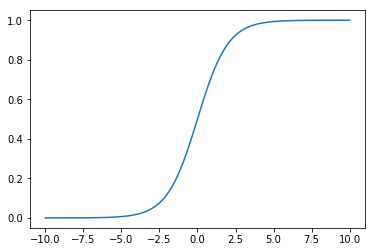

In [35]:
plt.plot(sample_z, sample_a)


In [64]:
class Sigmoid(Operation):
    
    def __init__(self, z):
        
        super().__init__([z])
        
    def compute(self, z_val):
        
        return 1/(1+np.exp(-z_val))

In [37]:
from sklearn.datasets import make_blobs # note that basically the make_blobs function allows for creating blobs
# this means that we can generate sample datasets with some centers

In [38]:
data = make_blobs(n_samples=50, n_features=2, centers=2, random_state=75) # centers essentially defines the number of centers

In [39]:
data

(array([[  7.3402781 ,   9.36149154],
        [  9.13332743,   8.74906102],
        [  1.99243535,  -8.85885722],
        [  7.38443759,   7.72520389],
        [  7.97613887,   8.80878209],
        [  7.76974352,   9.50899462],
        [  8.3186688 ,  10.1026025 ],
        [  8.79588546,   7.28046702],
        [  9.81270381,   9.46968531],
        [  1.57961049,  -8.17089971],
        [  0.06441546,  -9.04982817],
        [  7.2075117 ,   7.04533624],
        [  9.10704928,   9.0272212 ],
        [  1.82921897,  -9.86956281],
        [  7.85036314,   7.986659  ],
        [  3.04605603,  -7.50486114],
        [  1.85582689,  -6.74473432],
        [  2.88603902,  -8.85261704],
        [ -1.20046211,  -9.55928542],
        [  2.00890845,  -9.78471782],
        [  7.68945113,   9.01706723],
        [  6.42356167,   8.33356412],
        [  8.15467319,   7.87489634],
        [  1.92000795,  -7.50953708],
        [  1.90073973,  -7.24386675],
        [  7.7605855 ,   7.05124418],
        [  6

In [40]:
type(data)

tuple

In [41]:
features = data[0]
labels = data[1]

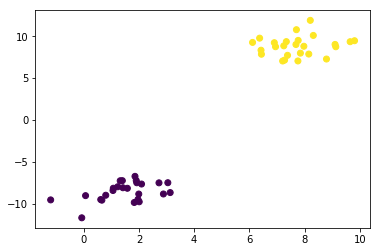

In [49]:
plt.scatter(features[:, 0], features[:,1], c=labels) # on the x-axis we will have feature 1 and on the y-axis feature 2
# the c attribute is used in order to color the data points, the idea here is that we can use the labels list as a reference to
# the kind of coloring that we wanna add

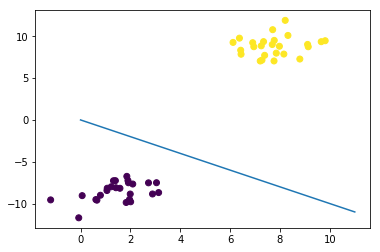

In [50]:
x = np.linspace(0, 11, 10)
y = -x # this is just for the purpose of manual demonstration
plt.scatter(features[:, 0], features[:,1], c=labels)
plt.plot(x, y)

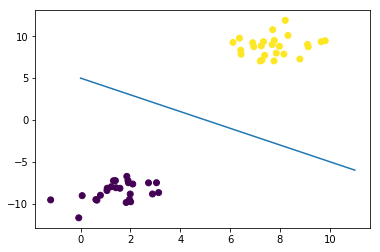

In [51]:
x = np.linspace(0, 11, 10)
y = -x + 5 # this is just for the purpose of manual demonstration
plt.scatter(features[:, 0], features[:,1], c=labels)
plt.plot(x, y)

Note that in the previous equation `y = -x + 5` both y and x are essentially features. Another way to think about this equation is that `f2 = -f1 + 5`. 

Lets consider the following equations:
`y = mx + b`
`y = -1x + 5`
Remember that both y and x are actually features
`feature2 = -1 * feature1 + 5`
`feature2 + 1*feature1 - 5 = 0`
`featureMatrix * [1, 1] - 5 = 0`, 

Actually note that `featureMatrix * [1, 1]` will actually give us `feature2 + 1*feature1`


#### (1,1) * f - 5 = 0

In [52]:
import numpy as np

In [53]:
np.array([1, 1]).dot(np.array([[8], [10]])) - 5 # note that the feature matrix in this case has dim 1*2, that is 1 row, 2 cols

array([13])

In [54]:
np.array([1, 1]).dot(np.array([[2], [-10]])) - 5

array([-13])

In [55]:
g = Graph()

Note that here we assume that we have already trained the model and we have found the weights, the weights here being the matrix `[1,1]`. Here we are simply showing the predicting phase

In [57]:
g.set_as_deafult()

In [58]:
x = Placeholder()

In [59]:
w = Variable([1, 1]) # essentially the weights

In [60]:
b =  Variable(-5)

In [61]:
z = add(matmul(w, x), b)

In [65]:
a = Sigmoid(z)

In [66]:
sess =  Session()

In [68]:
sess.run(operation=a, feed_dict={x:[8, 10]})

node is now a variable
node is now a placeholder
node is now an operation
<class '__main__.matmul'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.Variable'>
output of input_node: [1 1]
type of input_node: <class '__main__.Placeholder'>
output of input_node: [ 8 10]
printing operation output: 18
node is now a variable
node is now an operation
<class '__main__.add'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.matmul'>
output of input_node: 18
type of input_node: <class '__main__.Variable'>
output of input_node: -5
printing operation output: 13
node is now an operation
<class '__main__.Sigmoid'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.add'>
output of input_node: 13
printing operation output: 0.999997739675702


0.999997739675702

In [69]:
sess.run(operation=a, feed_dict={x:[2, -10]})

node is now a variable
node is now a placeholder
node is now an operation
<class '__main__.matmul'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.Variable'>
output of input_node: [1 1]
type of input_node: <class '__main__.Placeholder'>
output of input_node: [  2 -10]
printing operation output: -8
node is now a variable
node is now an operation
<class '__main__.add'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.matmul'>
output of input_node: -8
type of input_node: <class '__main__.Variable'>
output of input_node: -5
printing operation output: -13
node is now an operation
<class '__main__.Sigmoid'>
input nodes of this operation------------------------------------------
type of input_node: <class '__main__.add'>
output of input_node: -13
printing operation output: 2.2603242979035746e-06


2.2603242979035746e-06